# Análisis comparado de algoritmos de clasificacion: RF, eKDC, fKDC, eRF, fRF
## Intro
Somos fans de la estimación de densidad y se la queremos poner hasta a las tostadas, pero seamos justos: si un algoritmo "de cajita" le pasa el trapo a nuestra admirada metodología... es algo a tener en cuenta. Así que compararemos:
- Random Forest, `RF`
- Kernel Density Classifier (KDC) with Euclidean distance, `eKDC`
- Fermat-distance KDC, `fKDC`

Más tarde, si nos sale:
- `eRF. fRF`: Euclidean/Fermat-ehanced Random 

## Setup
No esperamos, _a priori_, que alguno de estos métodos domine unívocamente a los demás. Luego, quisiéramos comparar su _performance_ en una variedad de escenarios tal que nos permita comprender sus cualidades relativas. A tal fin, intentaremos:
### `X`: El _dataset_
Consideramos primero algunos ejemplos sintéticos en los que imaginamos la distancia en el grafo aproximará mejor la variedad de fondo, con $d$ conocidos (usualmente 1). Luego, probamos suerte en algunos datasets reales bien conocidos: `iris, digits, wine, (mnist)`. (Finalmente, lo soltamos en algo grande, a ver si se puede: CTR? spam? ???)
 - sintéticos (K=2 clases)
    - D=2 dimensiones: lunas, círculos concentricos, rectas perpendiculates (+, X)
    - (D=3: hélice)
  - naturales
    - iris (K=3 clases, D=4 dimensiones)
    - digits (K=10, D=64)
    - wine (K=8, D=??)

Los datasets "naturales" llevan consigo un problema adicional: la estimación de $d$, la dimensión de la variedad _embebida_ en $\mathbb{R}^D$. (Le dedicamos un minuto a esto | Asumimos $D = d$ y vemos qué pasa)

### `train_size`: Las condiciones de evaluación
Siendo `KDC` un método que extrae información de el grafo completo de la muestra $X_n$, sería razonable pensar que en contextos "adversos", cuando los datos de entrenamiento son escasos y el _testeo_ exhaustivo, tener una "buena" noción noción de distancia será más util que en la situación inversa. Decidimos probar tres escenarios a partir de _ratios_ de `train_size` (cf. documentación)
- `adverso`: $\text{train\_size} = p_{adv} (= 0.05)$
- `neutral`:  $\text{train\_size} = p_{neu} = \tfrac{1}{2}$
- `favorable`:  $\text{train\_size} = 1 - p_{adv} (= 0.95)$

### `rs`: El _estado aleatorio_ (`RandomState`) y la venerada reproducibilidad
> _A mayor $n$, menor varianza._ (Anónimo)

Como no confío en ninguno de estos experimentos, los hago todos por cuadruplicado. Idealmente, por $m\text{-uplicado}, n \rightarrow \infty$, pero el cómputo es lento y el número de escenarios, un producto cartesiano ambicioso. Optamos por el literal $m = 4$, _por ahora_.

Hay infinitas maneras de fijar el estado aleatorio de un experimento (lectora/lectoro: siéntase invitado a leer el código para comprender éste al dedillo). Aquí, en la `m`-ésima repetición del evento, inicializamos un estado aleatorio con la semilla $\text{seed} \in \left[m\right] = \{0, 1, \dots, m\}$, y se lo pasamos secuencialmente a las siguientes tareas:
- el llamado a `train_test_split` para definir las condiciones de evaluación
- (el fiteo de los métodos de estimación)
- (???)

### `classifier`: Los métodos de clasificación
Cf. Intro
#### Random Forest
#### (Euclidean) Kernel Density
#### Fermat-distance Kernel Density
<!-- #### Gradient Boosting Trees: LightGBM -->
#### RF/GBT w/distnace features

### `score`(s): Las métricas de evaluación
A cada combinación posible de `dataset, train_size, rs, classifier`, se la evaluará según
- su capacidad predictiva
  - en predicciones "duras" de la clase $\hat{y}_i = j, j\in\left[K\right]$ a la que pertenece la $i$-ésima observación, segúbn su precisión (`accuracy`),
  - (en predicciones "blandas", del vector $a_i \in \mathbb{R}^K$ de probabilidades de pertenencia a las $K$ clases posibles, de alguna manera a determinar)
- sus costos computacionales
  - en tiempo empírico de ejecución
    - en entrenamiento
    - en predicción
  - (en complejidad)




In [36]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from fermat import Fermat
from sklearn.datasets import load_iris, load_digits
import networkx as nx
# import igraph as ig
# import neo4j
%matplotlib inline

In [37]:
# EXPERIMENTAL: Widget support for mpl in notebooks
%matplotlib widget

In [38]:
PI = math.pi

In [39]:
# https://en.wikipedia.org/wiki/Trefoil_knot
def trefoil(n, start=0, noise_dims=47, end=2 * PI):
    T = start + (end - start) * np.random.rand(n)
    X_tref = np.array(
        [
            [
                np.sin(t) + 2 * np.sin(2 * t),  # X
                np.cos(t) - 2 * np.cos(2 * t),  # Y
                -np.sin(3 * t),                 # Z
            ]
            for t in T
        ]
    )
    X_noise = scipy.stats.norm.rvs(scale=0.05, size=(n, noise_dims))
    return np.concatenate([X_tref, X_noise], axis=1)


In [40]:
X = trefoil(1000, start=0, end=2*PI, noise_dims=0)

In [41]:
X_trefA = trefoil(500)

In [42]:
X_trefB = trefoil(500)

In [43]:
X_trefB[:, [0, 1, 2]] = X_trefB[:, [1, 2, 0]]

In [44]:
X_trefA.shape

(500, 50)

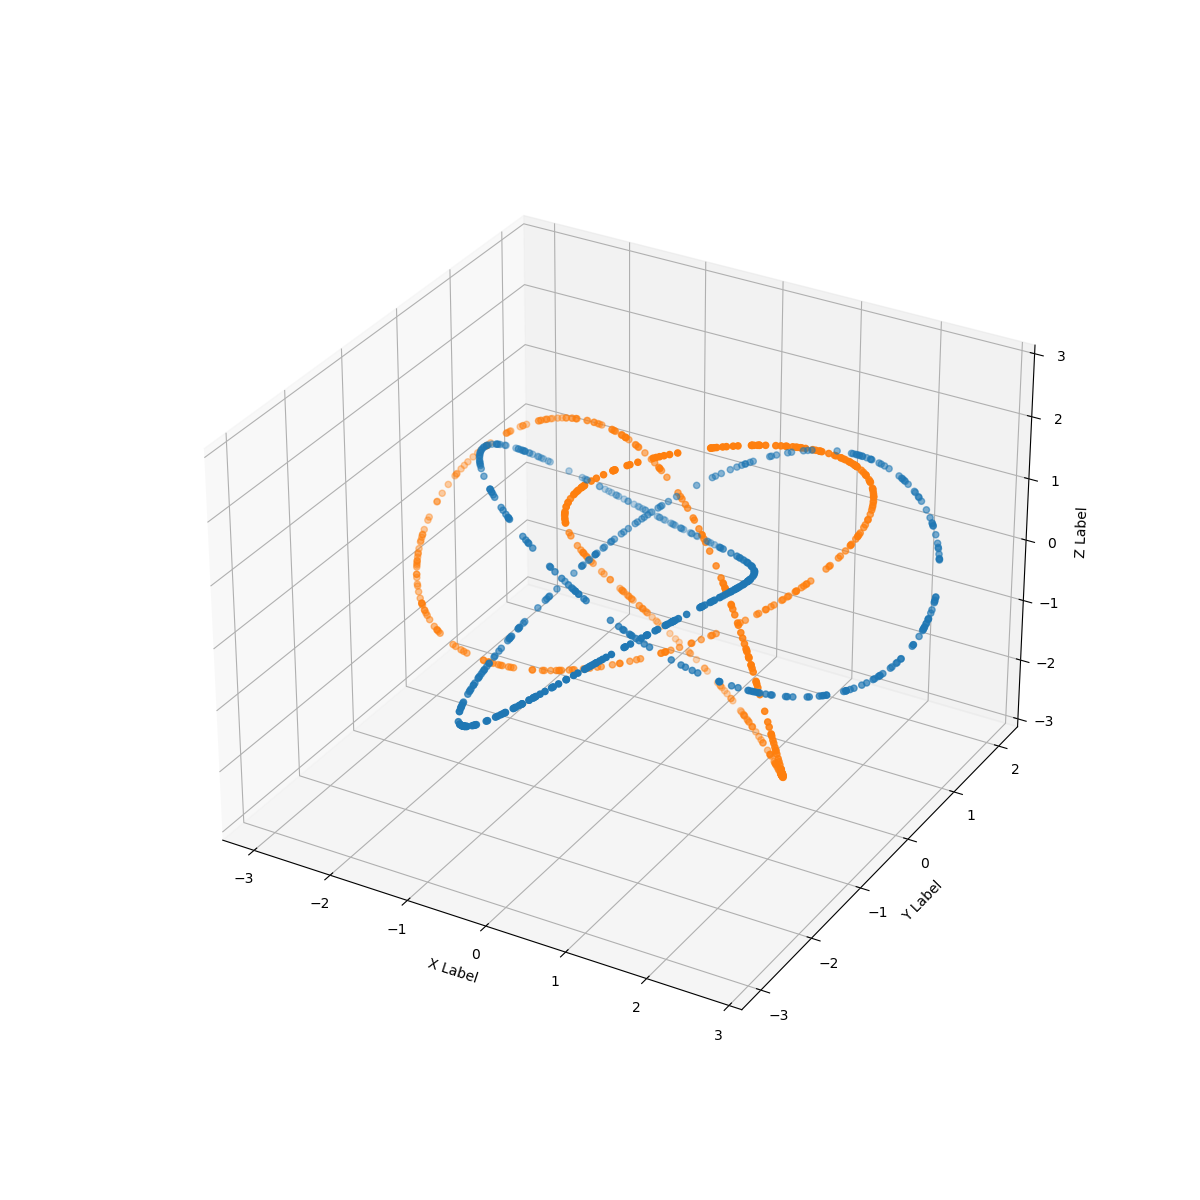

In [45]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for i, X in enumerate([X_trefA, X_trefB]):
    ax.scatter(xs=X[:,0], ys=X[:,1], zs=X[:,2], color=f"C{i}")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [46]:
from sklearn import datasets
X, y = datasets.make_moons(n_samples=500, noise=0.28)

In [47]:
palette = plt.cm.get_cmap("tab10")

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_56380/1171252967.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap("tab10")


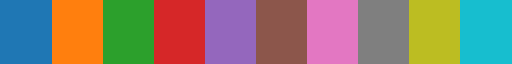

In [48]:
palette

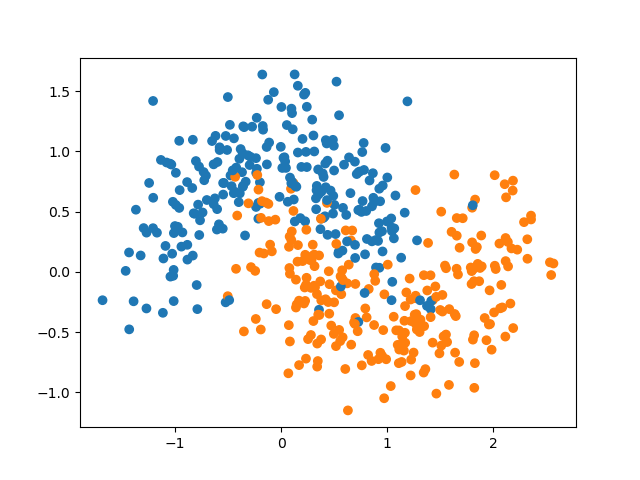

In [49]:
fig = plt.figure()
plt.scatter(x=X[:, 0], y=X[:, 1], color=palette(y))
plt.show()

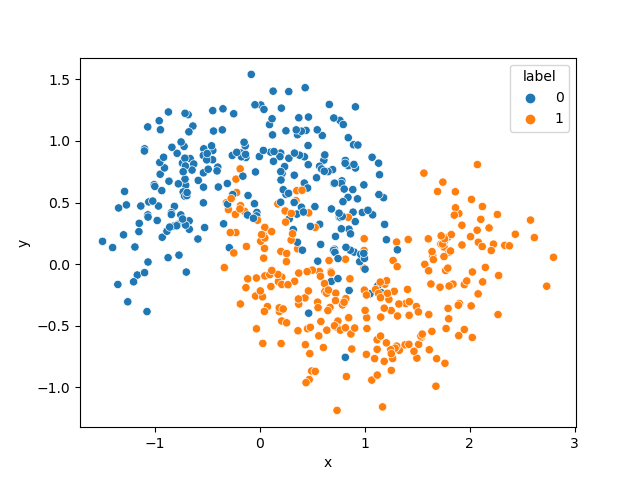

In [35]:
df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "label": y})
fig = plt.figure()
sns.scatterplot(x="x", y="y", hue="label", data=df)
plt.show()

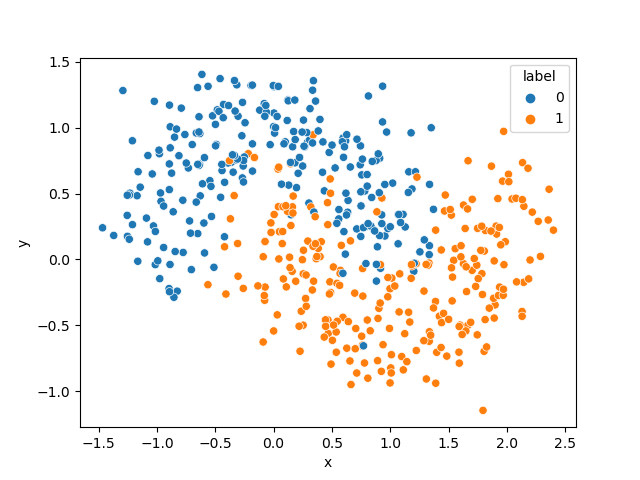

In [17]:
fig = plt.figure()
sns.scatterplot(x="x", y="y", hue="label", data=df)
plt.show()

In [50]:
norm_pdf = scipy.stats.norm.pdf


class EuclideanKDE:
    def __init__(self, kernel=norm_pdf, bandwith=1):
        self.kernel = kernel
        self.bandwith = bandwith

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        return self

    def density(self, X, log=True):
        densities = (self.bandwith**-self.dim_) * self.kernel(
            distance_matrix(X, self.X_) / self.bandwith
        ).mean(axis=1)
        return np.log(densities) if log else densities


In [51]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y  # , check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.special import softmax


class EuclideanKDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel=norm_pdf, bandwith=1):
        self.kernel = kernel
        self.bandwith = bandwith

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.densities_ = {
            cls: EuclideanKDE(self.kernel, self.bandwith).fit(X[y == cls])
            for cls in self.classes_
        }
        return self

    def decision_function(self, X):
        return np.column_stack(
            [self.densities_[cls].density(X) for cls in self.classes_]
        )

    def predict(self, X):
        D = self.decision_function(X)
        return self.classes_[np.argmax(D, axis=1)]

    def predict_proba(self, X, temp=1):
        D = self.decision_function(X)
        return softmax(D / temp, axis=1)


In [52]:
class FermatKDE:
    def __init__(self, kernel=norm_pdf, bandwith=1, alpha=2, path_method="FW"):
        self.kernel = kernel
        self.bandwith = bandwith
        self.alpha = alpha
        self.path_method = path_method

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        self.fermat_ = Fermat(self.alpha, self.path_method).fit(distance_matrix(X, X))
        self.distances_ = self.fermat_.get_distances()
        return self

    def density(self, X, log=True):
        densities = (self.bandwith**-self.dim_) * self.kernel(
            self.distances(X) / self.bandwith
        ).mean(axis=1)
        return np.log(densities) if log else densities

    def distances(self, X):
        distances_to_X = distance_matrix(X, self.X_) ** self.alpha
        return np.vstack([(d + self.distances_).min(axis=1) for d in distances_to_X])


In [53]:
from scipy.special import softmax


class FermatKDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel=norm_pdf, bandwith=1, alpha=2, path_method="FW"):
        self.kernel = kernel
        self.bandwith = bandwith
        self.alpha = alpha
        self.path_method = path_method

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.densities_ = {
            cls: FermatKDE(
                self.kernel, self.bandwith, self.alpha, self.path_method
            ).fit(X[y == cls])
            for cls in self.classes_
        }
        return self

    def decision_function(self, X):
        return np.column_stack(
            [self.densities_[cls].density(X) for cls in self.classes_]
        )

    def predict(self, X):
        D = self.decision_function(X)
        return self.classes_[np.argmax(D, axis=1)]

    def predict_proba(self, X, temp=1):
        D = self.decision_function(X)
        return softmax(D / temp, axis=1)


In [54]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.8)
eucclf = EuclideanKDEClassifier(bandwith=1).fit(X_train, y_train)
fmtclf = FermatKDEClassifier(alpha=2, bandwith=20).fit(X_train, y_train)
rfclf = RandomForestClassifier().fit(X_train, y_train)
rfclf2 = RandomForestClassifier().fit(
    np.concatenate([X_train, fmtclf.decision_function(X_train)], axis=1), y_train
)

In [56]:
for clf in [eucclf, fmtclf, rfclf]:
    print(repr(clf), ": ", accuracy_score(clf.predict(X_test), y_test))
print(
    repr(rfclf2),
    " - enhanced: ",
    accuracy_score(
        rfclf2.predict(
            np.concatenate([X_test, fmtclf.decision_function(X_test)], axis=1)
        ),
        y_test,
    ),
)


EuclideanKDEClassifier() :  0.8525
FermatKDEClassifier(bandwith=20) :  0.875
RandomForestClassifier() :  0.9075
RandomForestClassifier()  - enhanced:  0.855


In [57]:
df["eok"] = eucclf.predict(X) == df.label
df["fok"] = fmtclf.predict(X) == df.label
df["rok"] = rfclf.predict(X) == df.label

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


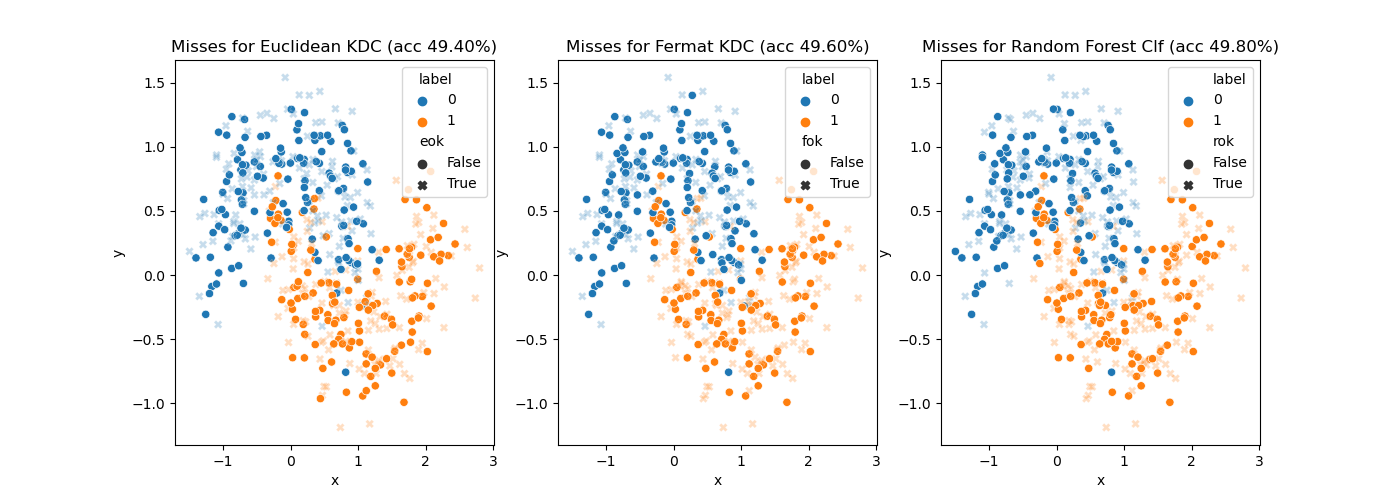

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
ax = axs[0]
sns.scatterplot(x="x", y="y", hue="label", style="eok", alpha=np.where(df.eok, 0.25, 1), data=df, ax=ax)
plt.legend()
ax.set_title(f"Misses for Euclidean KDC (acc {100 * df.eok.mean():.2f}%)")
ax = axs[1]
sns.scatterplot(x="x", y="y", hue="label", style="fok", alpha=np.where(df.fok, 0.25, 1), data=df, ax=ax)
plt.legend()
ax.set_title(f"Misses for Fermat KDC (acc {100 * df.fok.mean():.2f}%)")
ax = axs[2]
sns.scatterplot(x="x", y="y", hue="label", style="rok", alpha=np.where(df.rok, 0.25, 1), data=df, ax=ax)
plt.legend()
ax.set_title(f"Misses for Random Forest Clf (acc {100 * df.rok.mean():.2f}%)")
plt.show()

In [59]:
from sklearn.model_selection import GridSearchCV
import time


def get_seed(rng):
    return rng.bit_generator.random_raw() % 2**32


def trial(
    X,
    y,
    test_size,
    stratify,
    seed=None,
    euclid_grid=None,
    fermat_grid=None,
    enhanced=False,
):
    ret = {"locals": locals(), "classifiers": {}}
    rng = np.random.default_rng(seed)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        stratify=y if stratify else None,
        random_state=get_seed(rng),
    )
    ret["locals"]["y_test"] = y_test
    euclid_grid = euclid_grid or dict(bandwith=np.logspace(-2, 1, 5))
    fermat_grid = fermat_grid or dict(
        alpha=[1.25, 1.5, 2], bandwith=np.logspace(-2, 2, 5)
    )
    rf_grid = dict(ccp_alpha=np.logspace(-3, 0, 5))
    classifiers = {
        "rawRF": RandomForestClassifier(),
        "gridRF": GridSearchCV(RandomForestClassifier(), rf_grid),
        "eKDC": GridSearchCV(EuclideanKDEClassifier(), euclid_grid),
        "rawKDC": EuclideanKDEClassifier(),
        "fKDC": GridSearchCV(FermatKDEClassifier(), fermat_grid),
    }
    if enhanced:
        X_train_, X_test_, y_train_, y_test_ = train_test_split(
            X_train,
            y_train,
            test_size=0.2,
            stratify=y_train,
            random_state=get_seed(rng),
        )
        # TODO: write enhanced RF versions
        # cla = FermatKDEClassifier(alpha=2, bandwith=20).fit(X_train, y_train)
        # rfclf2 = RandomForestClassifier().fit(
        #     np.concatenate([X_train, fmtclf.decision_function(X_train)], axis=1), y_train
        # )
    for name, clf in classifiers.items():
        try:
            print(name)
            ret["classifiers"][name] = out = {}
            t0 = time.time()
            clf.fit(X_train, y_train)
            out["train_time"] = time.time() - t0
            t0 = time.time()
            out["preds"] = preds = clf.predict(X_test)
            out["test_time"] = time.time() - t0
            out["accuracy"] = accuracy_score(preds, y_test)
        except Exception as exc:
            print(exc)
            continue
    return ret


In [60]:
X_tref = np.vstack([X_trefA, X_trefB])
y_tref = np.hstack([np.zeros(X_trefA.shape[0]), np.ones(X_trefB.shape[0])])
print(X_tref.shape, y_tref.shape)
with np.errstate(divide='ignore'):
    results = trial(X_tref, y_tref, test_size=0.8, stratify=True, seed=None)
df = pd.DataFrame(results["classifiers"]).T
df

(1000, 50) (1000,)
rawRF
gridRF
eKDC
rawKDC
fKDC


,train_time,preds,test_time,accuracy
rawRF,0.076043,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0.006141,0.815
gridRF,1.809867,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...",0.006053,0.83
eKDC,0.031365,"[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0.013132,0.98375
rawKDC,0.000141,"[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...",0.012851,0.86
fKDC,0.416307,"[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0.031152,0.98375


In [61]:
X, y = datasets.make_moons(n_samples=500, noise=0.14)
with np.errstate(divide='ignore'):
    results = trial(X, y, test_size=0.8, stratify=True, seed=None)
df = pd.DataFrame(results["classifiers"]).T
df

rawRF
gridRF
eKDC
rawKDC
fKDC


,train_time,preds,test_time,accuracy
rawRF,0.049754,"[0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, ...",0.003919,0.9475
gridRF,1.247454,"[0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, ...",0.0039,0.945
eKDC,0.017669,"[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, ...",0.001641,0.9775
rawKDC,0.000061,"[0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, ...",0.001517,0.8325
fKDC,0.111982,"[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, ...",0.004848,0.99


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.8)
eucclf = EuclideanKDEClassifier(bandwith=1).fit(X_train, y_train)
fmtclf = FermatKDEClassifier(alpha=2, bandwith=20).fit(X_train, y_train)
rfclf = RandomForestClassifier().fit(X_train, y_train)
rfclf2 = RandomForestClassifier().fit(
    np.concatenate([X_train, fmtclf.decision_function(X_train)], axis=1), y_train
)

In [63]:
with np.errstate(divide='ignore'):
    results = trial(*load_digits(return_X_y=True), test_size=0.8, stratify=True, seed=234)
df = pd.DataFrame(results["classifiers"]).T
df

rawRF
gridRF
eKDC
rawKDC
fKDC


,train_time,preds,test_time,accuracy
rawRF,0.073381,"[0, 0, 8, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.011623,0.926287
gridRF,1.896219,"[0, 0, 8, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.010746,0.918637
eKDC,0.077726,"[0, 0, 8, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.05703,0.962448
rawKDC,0.000126,"[0, 0, 8, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.060862,0.967316
fKDC,0.651816,"[0, 0, 8, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.106782,0.967316


In [64]:
with np.errstate(divide='ignore'):
    results = trial(*load_digits(return_X_y=True), test_size=0.8, stratify=True, seed=234)
df = pd.DataFrame(results["classifiers"]).T
df

rawRF
gridRF
eKDC
rawKDC
fKDC


,train_time,preds,test_time,accuracy
rawRF,0.072992,"[0, 0, 9, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.011767,0.931154
gridRF,1.969967,"[0, 0, 8, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.01246,0.933241
eKDC,0.117555,"[0, 0, 8, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.069476,0.962448
rawKDC,0.000132,"[0, 0, 8, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.064577,0.967316
fKDC,0.684277,"[0, 0, 8, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.110341,0.967316


In [65]:
from sklearn.model_selection import GridSearchCV

In [68]:
euclid_grid = dict(bandwith=np.logspace(-2, 1, 5))
eucclf = GridSearchCV(EuclideanKDEClassifier(), euclid_grid).fit(X_train, y_train)

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_56380/3001414010.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_56380/3001414010.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_56380/3001414010.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_56380/3001414010.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_56380/3001414010.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities


In [72]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
X = [[0, 0], [1, 1], [1, 0], [0, 1]]
y = [0, 0, 1, 1]
rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X)
clf = SGDClassifier(max_iter=5)
clf.fit(X_features, y)

clf.score(X_features, y)


/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


1.0

In [73]:
def segment(n, start=[0, 0], end=[0, 1], noise_dims=48):
    slope = np.array(end) - np.array(start) + (end - start) * np.random.rand(n)
    X_tref = np.array(
        [
            [   
                np.sin(t) + 2 * np.sin(2 * t),  # X
                np.cos(t) - 2 * np.cos(2 * t),  # Y
                -np.sin(3 * t),                 # Z
            ]
            for t in T
        ]
    )
    X_noise = scipy.stats.norm.rvs(scale=0.05, size=(n, noise_dims))
    return np.concatenate([X_tref, X_noise], axis=1)

In [74]:
X_features.shape

(4, 100)